In [267]:
import sys
sys.path.append('/usr/local/opt/graph-tool/lib/python3.7/site-packages/')

In [268]:
import itertools
import graph_tool.all as gt
import joblib
import multiprocessing as mp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from time import time
from tqdm import *

plt.switch_backend("cairo")
matplotlib.use("cairo")

### Реализация 2-оптимального алгоритма.
Здесь и далее оранжевым цветов выделен результат работы алгоритма, желтым — настоящее дерево Штейнера, зелёным — рёбра, лежащие и там, и там. 

In [269]:
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def metric_closure(G):
    # Флойд
    dist = gt.shortest_distance(G, weights=G.ep["w"], directed=False, dense=True)
    dist = np.vstack([dist[v] for v in G.vertices()])
    
    # Построение метрического замыкания
    graph = gt.complete_graph(G.num_vertices(), directed=False)
    graph.ep["w"] = graph.new_edge_property("double")
    indices = np.triu_indices_from(dist, k=1)
    graph.ep["w"].a = np.ravel(np.asarray(dist[indices]))
    return graph

In [270]:
def approx_tree(G, V0):
    K_n = metric_closure(G)
    
    # Выбор подграфа, индуцированного терминальными вершинами
    V0_vfilt = K_n.new_vertex_property("bool")
    V0_vfilt.a[V0] = True
    K_V0 = gt.GraphView(K_n, vfilt=V0_vfilt.a)
    
    # Подсчет мин.остова и построение маски
    MST = gt.min_spanning_tree(K_V0, weights=K_n.ep["w"])
    mst_cost = np.sum(K_n.ep["w"].a[MST.a == 1])
    mask_2_opt = G.new_ep("bool")
    edges_before, edges_after = 0, 0
    for e in K_V0.edges():
        if MST[e]:
            edges_before += 1
            u, v = G.vertex(int(e.source())), G.vertex(int(e.target()))
            vpath, epath = gt.shortest_path(G, u, v, weights=G.ep["w"])
            for ee in epath:
                edges_after += 1
                mask_2_opt[ee] = True

    return mst_cost, mask_2_opt 

In [271]:
__cost_opt, __tree_opt = np.inf, None
def true_steiner_tree(G, V0):
    global __cost_opt, __tree_opt
    __cost_opt, __tree_opt = np.inf, None

    
    def mask(subset):
        global __cost_opt, __tree_opt
        # Выбираем подграф, индуцированный терминальными вершинами
        mask = np.full(G.num_vertices(), False)
        mask[V0] = True
        
        if len(subset) > 0:
            mask[np.array(subset)] = True
       
        H = gt.GraphView(G, vfilt=mask)
        conn = gt.label_largest_component(H)
        
        if np.sum(conn.a) != np.sum(mask):
            return np.inf
        
        # Находим мин остов и вычисляем его вес (на индуцированном графе)
        H_MST = gt.min_spanning_tree(H, weights=H.ep["w"])
        weight = np.sum(H.ep["w"].a[H_MST.a == 1])
        
        if weight <= __cost_opt:
            __cost_opt = weight
            __tree_opt = H_MST
        return weight
    
    st_weight = np.asscalar(np.min(joblib.Parallel(n_jobs=mp.cpu_count(), require="sharedmem")(
        joblib.delayed(mask)(s)
        for s in tqdm_notebook(powerset(np.setdiff1d(np.arange(n), V0)))
    )))
    
    return st_weight, __tree_opt.copy()

In [272]:
# Для проставления меток, полученному дереву
def highlight(G, mask_opt, mask_2_opt):
    G.ep["c"] = G.new_ep("string")
    G.ep["label"] = G.new_ep("string")
    
    for e in G.edges():
        if mask_opt[e] and mask_2_opt[e]:
            G.ep["c"][e] = "green"
        elif mask_opt[e]:
            G.ep["c"][e] = "blue"
        elif mask_2_opt[e]:
            G.ep["c"][e] = "orange"
        else:
            G.ep["c"][e] = "gray"
        
        G.ep["label"][e] = "{:.2f}".format(G.ep["w"][e])

# Набор графы с известным ответом

Последовательность, рассмотренная в замечании - на которой в пределе достигается наихудшее приближение. 
Терминальные вершины выделены зеленым. Реальное дерево Штейнера - голубым; дерево, полученное алгоритмом - желтое.
Итоговое качество аппроксимации: $ 2 - \frac{2}{|V_{0}|} $.

In [273]:
def init_graph():
    graph = gt.Graph(directed=False)
    
    graph.ep["w"] = graph.new_ep("double")
    graph.ep["label"] = graph.new_ep("string")
    graph.ep["color"] = graph.new_ep("string")
    graph.vp["c"] = graph.new_vp("string")
    return graph

In [274]:
def fill_labels(graph, inner, outer):
        graph.ep["w"][outer] = 2
        graph.ep["w"][inner] = 1
        graph.ep["color"][inner] = "yellow"
        graph.ep["color"][outer] = "orange"
        graph.ep["label"][outer] = "2"
        graph.ep["label"][inner] = "1"
        return graph

Number of terminal nodes: 3
Actual answer: 3
Algorithm's ouptut: 4.0


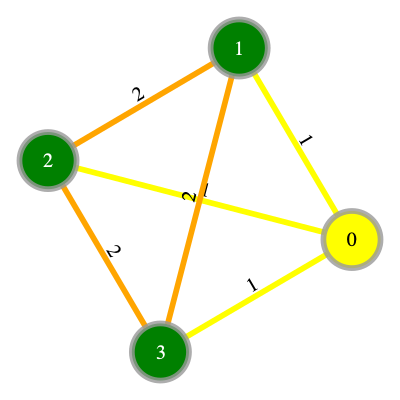

Number of terminal nodes: 5
Actual answer: 5
Algorithm's ouptut: 8.0


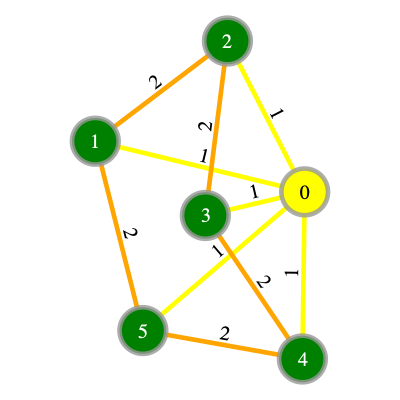

Number of terminal nodes: 7
Actual answer: 7
Algorithm's ouptut: 12.0


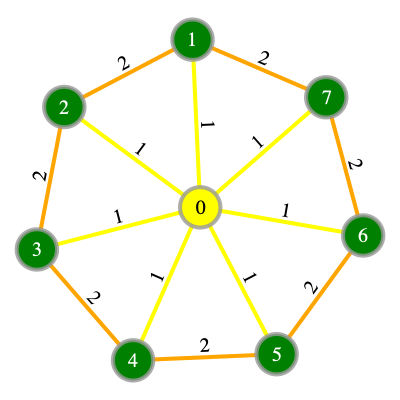

Number of terminal nodes: 9
Actual answer: 9
Algorithm's ouptut: 16.0


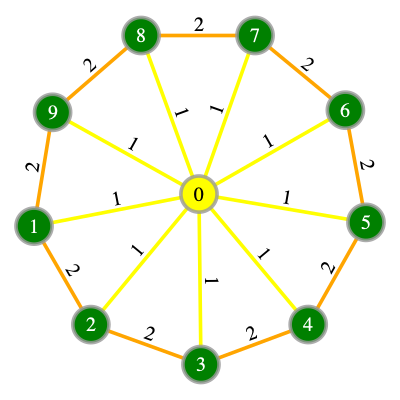

Number of terminal nodes: 11
Actual answer: 11
Algorithm's ouptut: 20.0


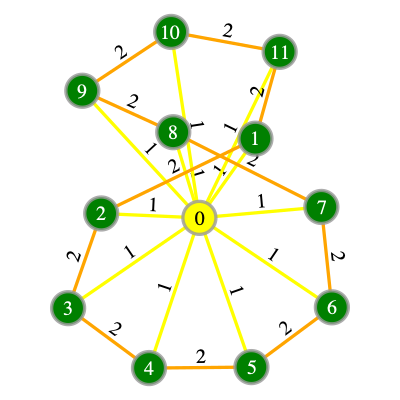

In [275]:
max_vertices = 10
min_vertices = 3
for i, n in enumerate(min_vertices + np.arange(max_vertices)[::2] + 1):
    G = init_graph()
    
    for j in range(n):
        v = G.add_vertex()
        if j == 0:
            G.vp["c"][v] = "yellow" 
        else:
            G.vp["c"][v] = "green"
    
    for j in range(1, n):
        inner_edge = G.add_edge(0, j)
        outer_edge = G.add_edge(j, max(1, (j + 1) % n))
        G = fill_labels(G, inner_edge, outer_edge)
    
    V0 = np.arange(1, n)
    cost_2_opt = approx_tree(G, V0)[0]
    num_terminal_vs = n - 1 
    print("Number of terminal nodes: {}\nActual answer: {}\nAlgorithm's ouptut: {}"\
          .format(num_terminal_vs, num_terminal_vs, cost_2_opt))
    
    gt.graph_draw(G,
                  vprops={"text" : G.vertex_index, 
                          "fill_color" : G.vp["c"],
                          "font_size" : 20},
                  eprops={"text" : G.ep["label"], 
                          "color" : G.ep["color"],
                          "font_size" : 20}, 
                  output_size=(400,400)); 

## $|V| = |V_0|$ - поиск минимального остовного дерева

In [276]:
def graph_init2(num):
    graph = gt.complete_graph(num, directed=False);
    graph.ep["w"] = graph.new_ep("double")
    graph.ep["w"].a = np.random.randint(low=1, high=100, size=graph.num_edges())
    graph.vp["fc"] = graph.new_vp("string")
    graph.vp["c"] = graph.new_vp("string")
    return graph


|V| = 5, |V0| = 5, |E| = 10
Weight 2_opt - 106.0,
Weight opt - 106.0,
Approximation - 1.0


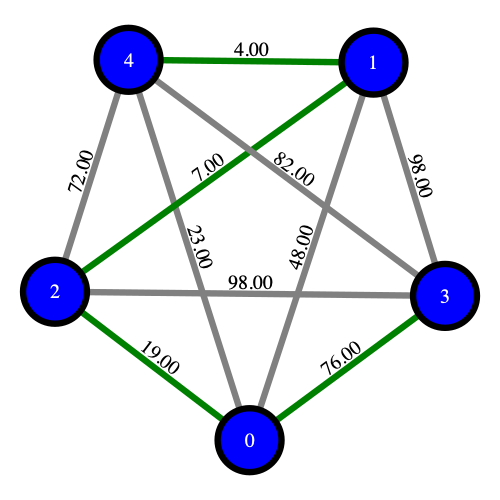


|V| = 6, |V0| = 6, |E| = 15
Weight 2_opt - 76.0,
Weight opt - 76.0,
Approximation - 1.0


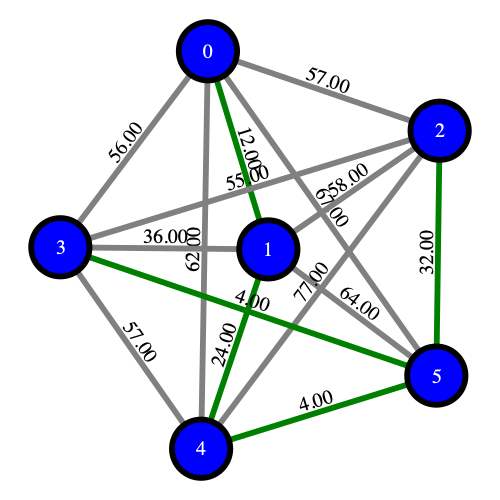


|V| = 7, |V0| = 7, |E| = 21
Weight 2_opt - 154.0,
Weight opt - 154.0,
Approximation - 1.0


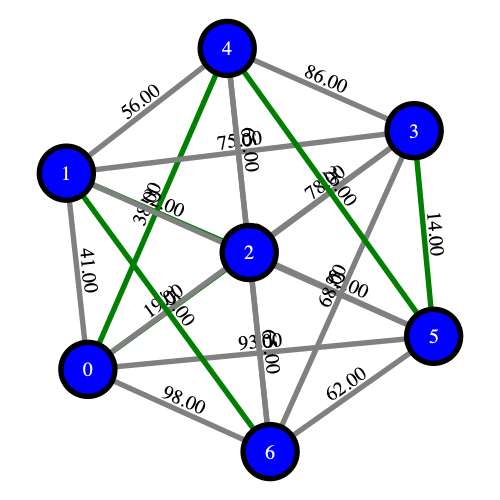

In [277]:
n_list = np.array([5, 6, 7])
k_list = n_list

for i in range(len(n_list)):
    n, k = n_list[i], k_list[i]
    G = graph_init2(n)
    
    V0 = np.random.choice(np.arange(n), k, replace=False)
    for v in G.vertices():
        if int(v) in V0:
            G.vp["fc"][v] = "blue"
        G.vp["c"][v] = "black"
            
    cost_2_opt, mask_2_opt = approx_tree(G, V0)
    cost_opt, mask_opt = true_steiner_tree(G, V0)
    highlight(G, mask_opt, mask_2_opt)
    
    print("|V| = {}, |V0| = {}, |E| = {}".format(n, k, G.num_edges()))

    print("Weight 2_opt - {},\nWeight opt - {},\nApproximation - {}"\
          .format(cost_2_opt, cost_opt, cost_2_opt / cost_opt))
    
    gt.graph_draw(G, 
                  vprops={"fill_color" : G.vp["fc"], 
                          "text" : G.vertex_index, 
                          "color" : G.vp["c"],
                          "font_size" : 20},
                  eprops={"color" : G.ep["c"], 
                          "text" : G.ep["label"],
                          "font_size" : 20},
                  output_size=(500, 500));

## Случайные графы в модели Эрдеша-Реньи
Сгенерируем случайные графы в модели Эрдёша-Реньи. Ответ для них заранее неизвестен и ищется экспоненциальным перебором.

In [278]:
def graph_init3(graph):
    graph.ep["w"] = graph.new_ep("double")
    graph.ep["w"].a = np.random.rand(graph.num_edges()) * 42
    graph.vp["fc"] = graph.new_vp("string")
    graph.vp["c"] = graph.new_vp("string")
    return graph


|V| = 5, |V0| = 3, |E| = 5, p = 0.7
Weight 2_opt - 54.98828119429296,
Weight opt - 54.98828119429296,
Approximation - 1.0


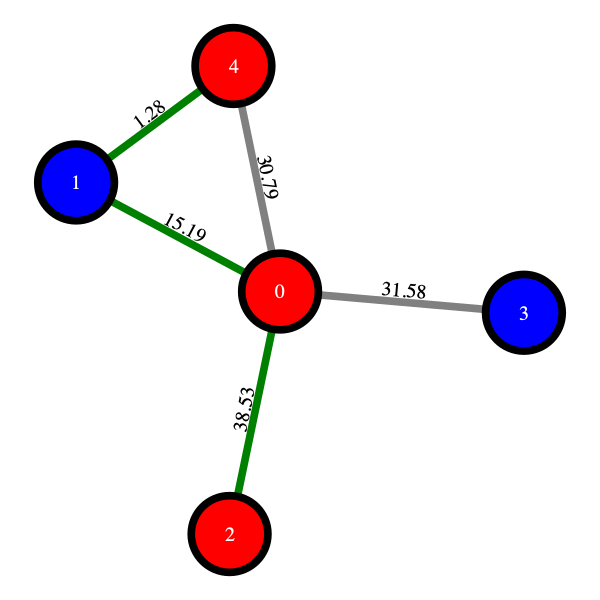


|V| = 10, |V0| = 5, |E| = 25, p = 0.5
Weight 2_opt - 53.97832960498141,
Weight opt - 53.978329604981425,
Approximation - 0.9999999999999998


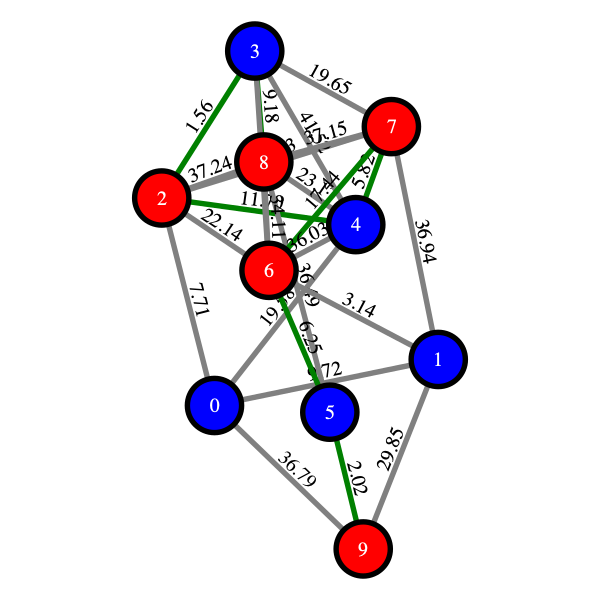


|V| = 20, |V0| = 7, |E| = 57, p = 0.25
Weight 2_opt - 102.9520692015421,
Weight opt - 96.22657444738068,
Approximation - 1.0698922807216742


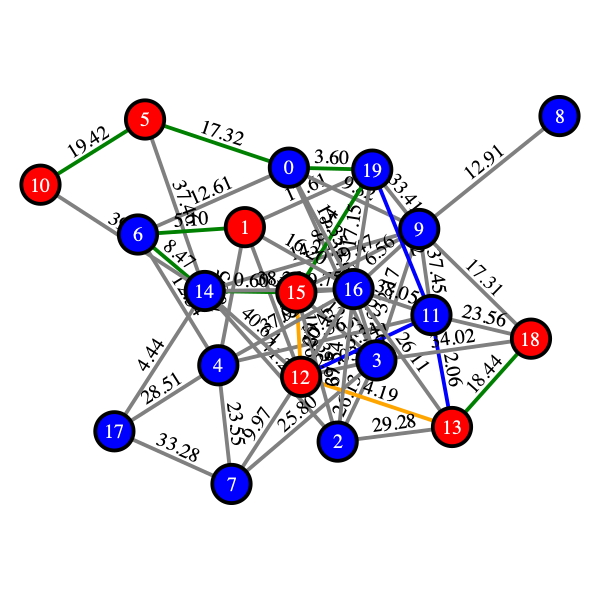

In [279]:
np.random.seed(int(time()))
n_list = np.array([5, 10, 20])
k_list = np.array([3, 5, 7])
p_list = np.array([0.7, 0.5, 0.25])

for i in range(len(n_list)):
    n, k, p = n_list[i], k_list[i], p_list[i]
    G = gt.random_graph(n, lambda: np.random.poisson(n * p), directed=False);
    conn = gt.label_largest_component(G)
    if np.sum(conn.a) != n:
        i -= 1
        continue
    G = graph_init3(G)
    
    V0 = np.random.choice(np.arange(n),  k, replace=False)
    for v in G.vertices():
        G.vp["fc"][v] = "red" if int(v) in V0 else "blue"
        G.vp["c"][v] = "black"
    
    cost_2_opt, mask_2_opt = approx_tree(G, V0)
    cost_opt, mask_opt = true_steiner_tree(G, V0)
    
    print("|V| = {}, |V0| = {}, |E| = {}, p = {}".format(n, k, G.num_edges(), p))
    print("Weight 2_opt - {},\nWeight opt - {},\nApproximation - {}"\
          .format(cost_2_opt, cost_opt, cost_2_opt / cost_opt))
    
    highlight(G, mask_opt, mask_2_opt)
    gt.graph_draw(G, 
                  vprops={"fill_color" : G.vp["fc"], 
                          "text" : G.vertex_index, 
                          "color" : G.vp["c"],
                          "font_size" : 20},
                  eprops={"color" : G.ep["c"], 
                          "text" : G.ep["label"],
                          "font_size" : 20},
                  output_size=(600, 600));

## Полные графы со случайными весами и множествами терминальных вершин

In [280]:
def graph_init4(num):
    graph = gt.complete_graph(num, directed=False);
    graph.ep["w"] = graph.new_ep("double")
    graph.ep["w"].a = np.random.rand(graph.num_edges()) * 50
    graph.vp["fc"] = graph.new_vp("string")
    graph.vp["c"] = graph.new_vp("string")
    return graph


|V| = 9, |V0| = 4, |E| = 36
Weight 2_opt - 20.595938089902592,
Weight opt - 20.13192452619041,
Approximation - 1.0230486441129127


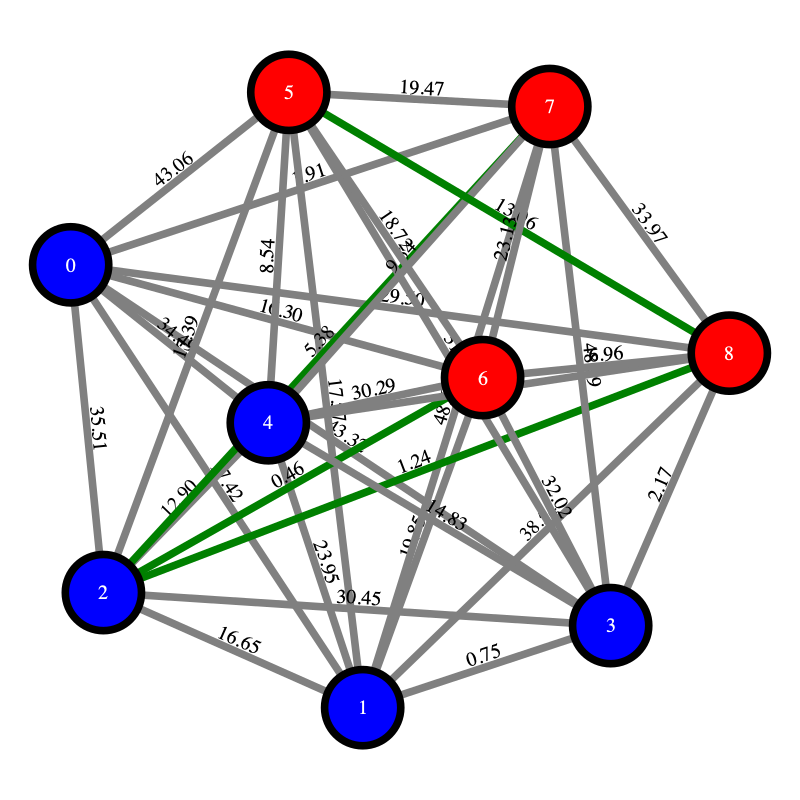


|V| = 7, |V0| = 6, |E| = 21
Weight 2_opt - 51.30635777758653,
Weight opt - 49.468259799269,
Approximation - 1.0371571182365442


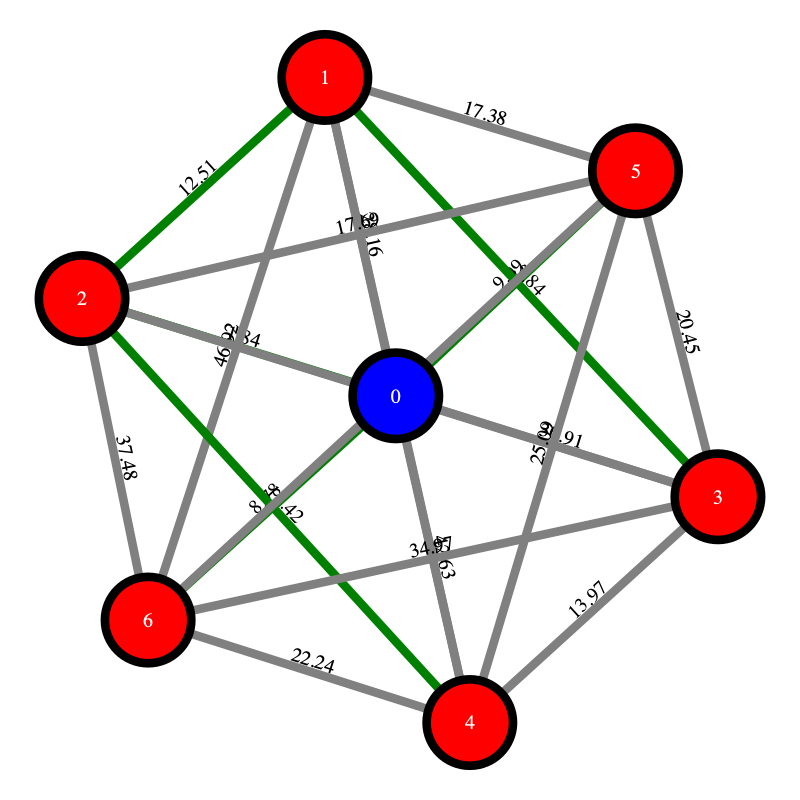


|V| = 4, |V0| = 2, |E| = 6
Weight 2_opt - 1.6025454323396304,
Weight opt - 1.6025454323396304,
Approximation - 1.0


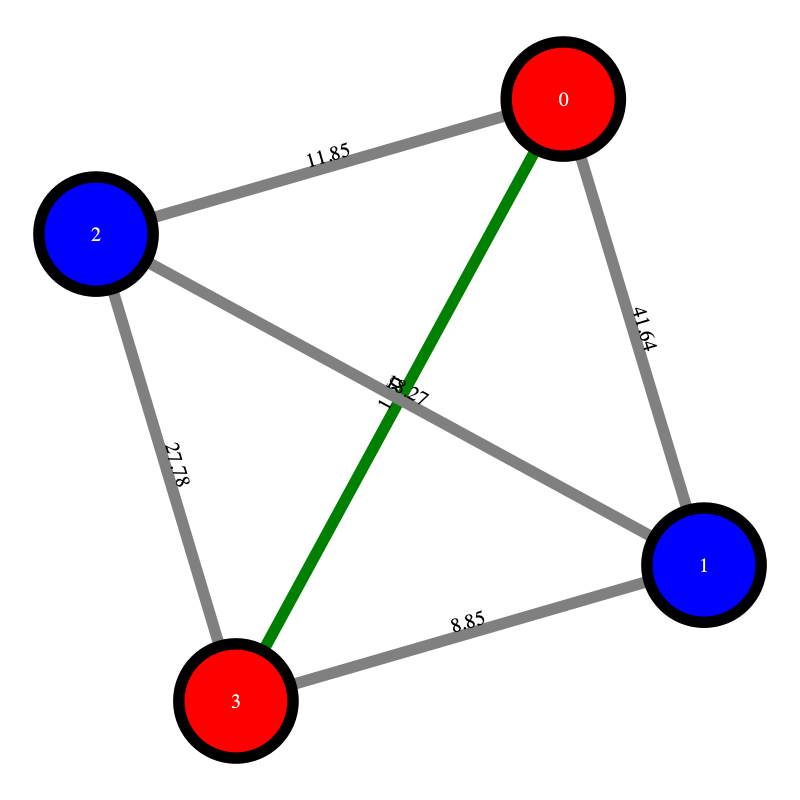

In [281]:
n_list = np.random.randint(low=4, high=15, size=3)
k_list = np.array([np.random.randint(low=2, high=n) for n in n_list])

for i in range(len(n_list)):
    n, k = n_list[i], k_list[i]
    G = graph_init4(n)
    
    V0 = np.random.choice(np.arange(n),  k, replace=False)
    for v in G.vertices():
        G.vp["fc"][v] = "red" if int(v) in V0 else "blue"
        G.vp["c"][v] = "black" 
    
    cost_2_opt, mask_2_opt = approx_tree(G, V0)
    cost_opt, mask_opt = true_steiner_tree(G, V0)
    highlight(G, mask_opt, mask_2_opt)
    
    print("|V| = {}, |V0| = {}, |E| = {}".format(n, k, G.num_edges()))
   
    print("Weight 2_opt - {},\nWeight opt - {},\nApproximation - {}"\
          .format(cost_2_opt, cost_opt, cost_2_opt / cost_opt))
    
    gt.graph_draw(G, 
                  vprops={"fill_color" : G.vp["fc"], 
                          "text" : G.vertex_index, 
                          "color" : G.vp["c"],
                          "font_size" : 20},
                  eprops={"color" : G.ep["c"], 
                          "text" : G.ep["label"],
                          "font_size" : 20},
                  output_size=(800, 800));